In [2]:
%matplotlib inline

import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt
from src.utils.imageProcessing import *

(1080, 1080, 3)


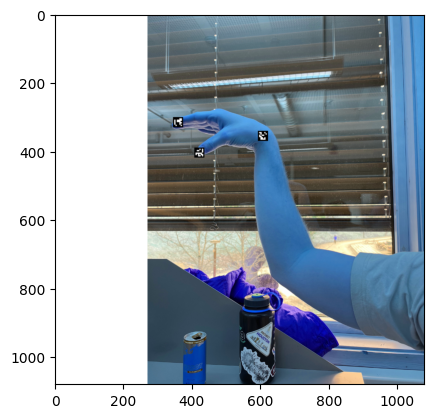

In [3]:
I = cv.imread("./data/raw/img/openHand_3pt_Aruco.png", cv.COLOR_BGR2GRAY)
gray = rgb_to_gray(I)
print(I.shape)
plt.imshow(I, cmap="gray")

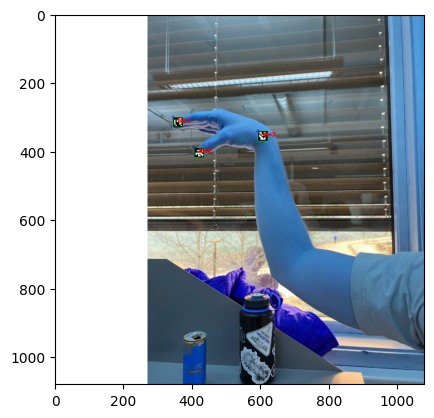

In [4]:
gray = I

parameters = cv.aruco.DetectorParameters()
arucoDict = cv.aruco.getPredefinedDictionary(cv.aruco.DICT_6X6_250)
detector = cv.aruco.ArucoDetector(arucoDict, parameters)

allCorners, ids, rejectedImgPoints = detector.detectMarkers(gray)

if len(allCorners) > 0:
    cv.aruco.drawDetectedMarkers(I, allCorners, ids)
else:
    print("No ArUco markers detected")

plt.imshow(I)


[606 355]


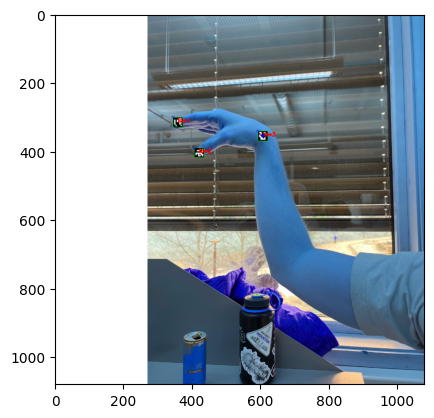

In [5]:
def calcCenter(corners):
        c = np.array(corners).T
        x = int(np.sum(c[0])//4)
        y = int(np.sum(c[1])//4)
        return np.array([x,y])

centers = []

# for corners in allCorners:
#     center = calcCenter(corners)
#     centers.append(center)
#     I = cv.circle(I, center, radius=5, color=(0, 0, 255), thickness=-5) #plot the centers


end_effector_position = None

if np.any(ids==3): 
        center = calcCenter(allCorners[np.where(ids==3)[0][0]])
        centers.append(center)
        I = cv.circle(I, center, radius=5, color=(0, 0, 255), thickness=-5) #plot the centers

        end_effector_position = center
        plt.imshow(I)
        print(center)
else: 
        print("Marker 3 not found")

In [6]:
def calculate_inverse_kinematics(target_pos_px, image_width, image_height):
    # Konverter pikselposisjon til "meter" i robotens koordinatsystem
    if target_pos_px is None: 
        return np.array([0, 0])
    
    scale_x, scale_y = 2.0 / image_width, 2.0 / image_height
    x, y = target_pos_px[0] * scale_x - 1, target_pos_px[1] * \
        scale_y - 1  # Juster slik at (0,0) er i midten

    # Beregn invers kinematikk (forenklet for 2D planar robot)
    a1, a2 = 0.5, 0.5  # Armens lengder
    d = np.sqrt(x**2 + y**2)

    if d > (a1 + a2):
        print("Målet er utenfor rekkevidde.")
        return np.array([1.60039637, 2.39702963])

    cos_theta2 = (d**2 - a1**2 - a2**2) / (2 * a1 * a2)
    theta2 = np.arccos(cos_theta2)
    theta1 = np.arctan2(y, x) - np.arctan2(a2 *
                                           np.sin(theta2), a1 + a2 * np.cos(theta2))

    return np.array([theta1, theta2])

In [7]:

import matplotlib.patches as patches

def draw_robot_arm(q, ax, end_effector_closed):
    a1, a2 = 0.5, 0.5  # Arm lengths
    # Calculate the positions of the first and second joint based on joint angles
    joint1 = (a1 * np.cos(q[0]), a1 * np.sin(q[0]))
    joint2 = (joint1[0] + a2 * np.cos(q[0] + q[1]), joint1[1] + a2 * np.sin(q[0] + q[1]))

    # Clear previous drawing
    ax.clear()
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    # Draw the robot arm: base -> first joint -> second joint
    ax.plot([0, joint1[0]], [0, joint1[1]], 'r-', lw=4)  # From base to first joint
    ax.plot([joint1[0], joint2[0]], [joint1[1], joint2[1]], 'b-', lw=4)  # From first joint to second joint
    ax.plot(joint1[0], joint1[1], 'ko', markersize=5)  # Pivot point

    # End effector enhancements
    effector_length = 0.15  # Length of the end effector 'jaws'
    angle_offset = np.pi / 6  # Angle for the cooler look
    pinch_angle = np.pi / 6  # Constant angle for the pinching joint
    joint_angle = q[0] + q[1]  # Total angle of the end effector

    # Calculate positions for the end effector 'jaws'
    if end_effector_closed:
        left_jaw = (joint2[0] + effector_length * np.cos(joint_angle - angle_offset),
                    joint2[1] + effector_length * np.sin(joint_angle - angle_offset))
        right_jaw = (joint2[0] + effector_length * np.cos(joint_angle + angle_offset),
                     joint2[1] + effector_length * np.sin(joint_angle + angle_offset))
    else:
        left_jaw = (joint2[0] + effector_length * np.cos(joint_angle - 2*angle_offset),
                    joint2[1] + effector_length * np.sin(joint_angle - 2*angle_offset))
        right_jaw = (joint2[0] + effector_length * np.cos(joint_angle + 2*angle_offset),
                     joint2[1] + effector_length * np.sin(joint_angle + 2*angle_offset))

    # Calculate pinching joint positions
    left_pinch = (left_jaw[0] + effector_length * 0.5 * np.cos(np.pi/2 + joint_angle - angle_offset - pinch_angle),
                  left_jaw[1] + effector_length * 0.5 * np.sin(np.pi/2 + joint_angle - angle_offset - pinch_angle))
    right_pinch = (right_jaw[0] + effector_length * 0.5 * np.cos(-np.pi/2 + joint_angle + angle_offset + pinch_angle),
                   right_jaw[1] + effector_length * 0.5 * np.sin(-np.pi/2 + joint_angle + angle_offset + pinch_angle))
    
    # Draw the end effector and pinching joints
    ax.plot([joint2[0], left_jaw[0]], [joint2[1], left_jaw[1]], 'k-', lw=2)  # Left 'jaw'
    ax.plot([joint2[0], right_jaw[0]], [joint2[1], right_jaw[1]], 'k-', lw=2)  # Right 'jaw'
    ax.plot([left_jaw[0], left_pinch[0]], [left_jaw[1], left_pinch[1]], 'g-', lw=2)  # Left pinching joint
    ax.plot([right_jaw[0], right_pinch[0]], [right_jaw[1], right_pinch[1]], 'g-', lw=2)  # Right pinching joint

    plt.pause(0.001)  # A short pause to ensure the plot updates



[606 355]
[1.60039637 2.39702963]


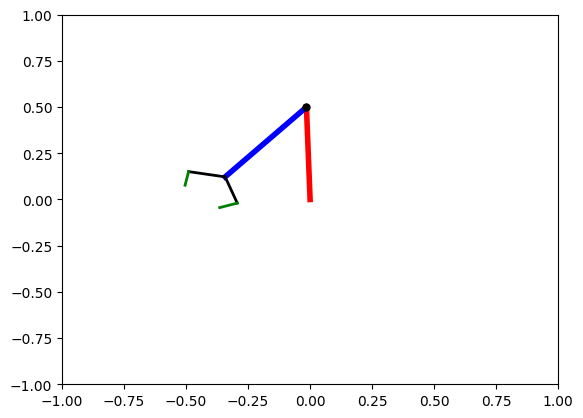

/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_13956/393396422.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [8]:

q = calculate_inverse_kinematics((end_effector_position[1], end_effector_position[0]), I.shape[1], I.shape[0])
print(end_effector_position)
print(q)
fig, ax = plt.subplots()

draw_robot_arm(q, ax, 0)
fig.show()

In [9]:

import cv2 as cv
import numpy as np 

frameWidth = 450
frameHeight = 640
cap = cv.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10,150)

parameters = cv.aruco.DetectorParameters()
arucoDict = cv.aruco.getPredefinedDictionary(cv.aruco.DICT_6X6_250)
detector = cv.aruco.ArucoDetector(arucoDict, parameters)


counters = []

# Assume calcCenter, calculate_inverse_kinematics, and draw_robot_arm are defined elsewhere

plt.ion()  # Turn on interactive mode
figure, ax = plt.subplots()

while True:
    success, img = cap.read()
    if not success:
        break  # If the frame is not successfully captured, break out of the loop

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    allCorners, ids, rejectedImgPoints = detector.detectMarkers(gray)

    if ids is not None and np.any(ids == 1):
        center = calcCenter(allCorners[np.where(ids == 1)[0][0]])
        img = cv.circle(img, center, radius=5, color=(0, 0, 255), thickness=-1)
        end_effector_position = center
    

    if len(allCorners) > 0:
        cv.aruco.drawDetectedMarkers(img, allCorners, ids)


    q = calculate_inverse_kinematics(end_effector_position, img.shape[0], img.shape[1])  # Adjust based on actual function signature
    draw_robot_arm(q, ax, 0)  # Make sure this function correctly plots on 'ax'
    ax.clear()

    plt.draw()
    
    fig.show()

    cv.imshow("Result", img)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()
plt.close()


2024-03-08 22:08:41.013 Python[13956:1005447] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
